# Fraud Detection System for Company ABC

## Problem Statement
Company ABC, a major credit card company, faces challenges with their existing fraud detection system. 
The current system exhibits slow responsiveness in recognizing new patterns of fraud, leading to significant financial losses. 
To address this issue, they aim to design and implement an algorithm that can efficiently identify and flag potentially fraudulent transactions.

The data provided consists of two tables: "cc_info," containing general credit card and cardholder information, 
and "transactions," containing details of credit card transactions that occurred between August 1st and October 30th.

## Objective
The primary goal of this project is to build an advanced fraud detection system using neural networks 
to identify transactions that appear unusual and potentially fraudulent. 


## Data Loading and Exploration

Let's start by loading the provided datasets and having a quick look at the first few rows of each dataset to understand their structure.


In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data
transactions = pd.read_csv('transactions.csv')
cc_info = pd.read_csv('cc_info.csv')

# Display the first few rows
transactions.head(), cc_info.head()



(        credit_card                 date  transaction_dollar_amount  \
 0  1003715054175576  2015-09-11 00:32:40                      43.78   
 1  1003715054175576  2015-10-24 22:23:08                     103.15   
 2  1003715054175576  2015-10-26 18:19:36                      48.55   
 3  1003715054175576  2015-10-22 19:41:10                     136.18   
 4  1003715054175576  2015-10-26 20:08:22                      71.82   
 
         Long        Lat  
 0 -80.174132  40.267370  
 1 -80.194240  40.180114  
 2 -80.211033  40.313004  
 3 -80.174138  40.290895  
 4 -80.238720  40.166719  ,
         credit_card      city state  zipcode  credit_card_limit
 0  1280981422329509    Dallas    PA    18612               6000
 1  9737219864179988   Houston    PA    15342              16000
 2  4749889059323202    Auburn    MA     1501              14000
 3  9591503562024072   Orlando    WV    26412              18000
 4  2095640259001271  New York    NY    10001              20000)

Let's proceed with a detailed exploratory data analysis (EDA) to understand the distributions, patterns, and relationships in the data.


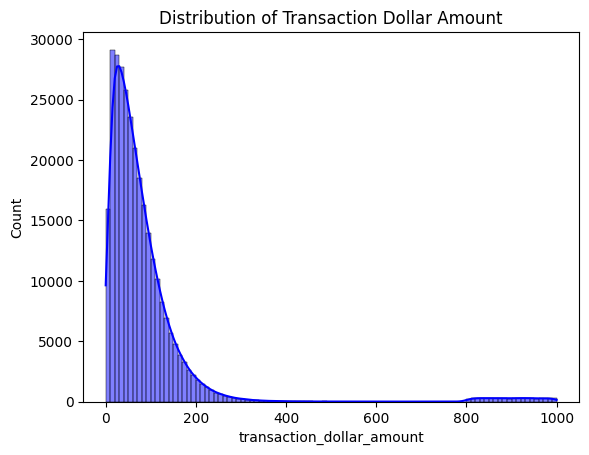

In [28]:
# Distribution of transaction_dollar_amount
sns.histplot(transactions['transaction_dollar_amount'], kde=True, bins=100, color='blue')
plt.title('Distribution of Transaction Dollar Amount')
plt.show()


The distribution of the transaction amounts is right-skewed, indicating that most transactions are of smaller amounts, with fewer transactions of higher values.


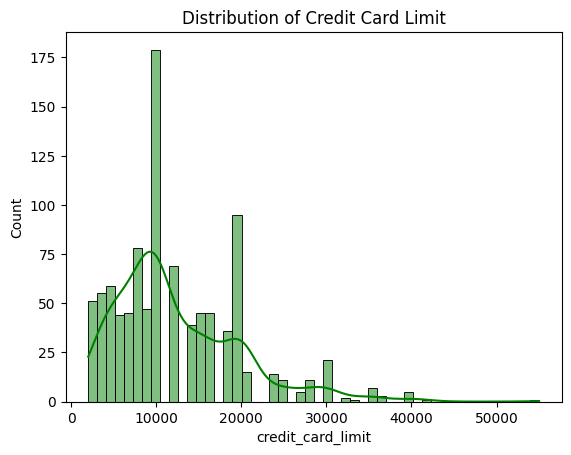

In [29]:
# Distribution of credit_card_limit
sns.histplot(cc_info['credit_card_limit'], kde=True, bins=50, color='green')
plt.title('Distribution of Credit Card Limit')
plt.show()


Many cardholders have limits set around the $5,000, $10,000, and $15,000 marks, with fewer cardholders having very high or very low credit limits.


In [30]:
transactions['date'] = pd.to_datetime(transactions['date'])


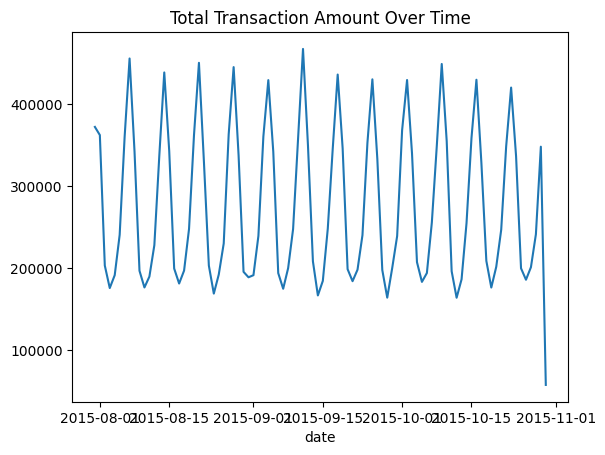

In [31]:
# Transactions over time
daily_transactions = transactions.groupby(transactions['date'].dt.date)['transaction_dollar_amount'].sum()
daily_transactions.plot()
plt.title('Total Transaction Amount Over Time')
plt.show()





The time-series plot shows a consistent pattern of transactions, without any significant spikes or drops.

Next, we'll visualize the transactions on a map to understand their spatial distribution.


In [32]:
import folium
# Map visualization of transactions
sample_data = transactions.sample(10000)
m = folium.Map(location=[sample_data['Lat'].mean(), sample_data['Long'].mean()], zoom_start=4)
for _, row in sample_data.iterrows():
    folium.CircleMarker(location=[row['Lat'], row['Long']], radius=3, color="blue", fill=True, fill_color="blue").add_to(m)
m


The map provides a spatial view of the transactions, helping identify regions with higher transaction densities.

With the EDA completed, let's move on to data preprocessing and feature engineering.


## Data Preprocessing and Feature Engineering

In this step, we'll merge the two datasets to create a comprehensive dataset. Additionally, we'll extract useful features from the date column and calculate the ratio of the transaction amount to the credit limit.


In [33]:
# Merge the datasets
merged_data = pd.merge(transactions, cc_info, on='credit_card', how='left')

# Extract features from the 'date' column
merged_data['date'] = pd.to_datetime(merged_data['date'])
merged_data['day_of_week'] = merged_data['date'].dt.dayofweek
merged_data['hour_of_day'] = merged_data['date'].dt.hour
merged_data['day_of_month'] = merged_data['date'].dt.day
merged_data['month'] = merged_data['date'].dt.month

# Calculate the ratio of transaction amount to credit limit
merged_data['transaction_to_limit_ratio'] = merged_data['transaction_dollar_amount'] / merged_data['credit_card_limit']

merged_data.head()


credit_card                date  transaction_dollar_amount       Long  \
0  1003715054175576 2015-09-11 00:32:40                      43.78 -80.174132   
1  1003715054175576 2015-10-24 22:23:08                     103.15 -80.194240   
2  1003715054175576 2015-10-26 18:19:36                      48.55 -80.211033   
3  1003715054175576 2015-10-22 19:41:10                     136.18 -80.174138   
4  1003715054175576 2015-10-26 20:08:22                      71.82 -80.238720   

         Lat     city state  zipcode  credit_card_limit  day_of_week  \
0  40.267370  Houston    PA    15342              20000            4   
1  40.180114  Houston    PA    15342              20000            5   
2  40.313004  Houston    PA    15342              20000            0   
3  40.290895  Houston    PA    15342              20000            3   
4  40.166719  Houston    PA    15342              20000            0   

   hour_of_day  day_of_month  month  transaction_to_limit_ratio  
0            0            11      9                    0.002189  
1           22            24     10                    0.005158  
2           18            26     10                    0.002427  
3           19            22     10                    0.006809  
4           20            26     10                    0.003591

The data has been preprocessed, and new features have been engineered. The next step is to apply an anomaly detection algorithm to identify potentially fraudulent transactions.


## Modeling - Anomaly Detection with Isolation Forest

Using the Isolation Forest algorithm, we'll identify anomalies in the dataset. These anomalies represent potentially fraudulent transactions.


In [34]:
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler

# Data preparation for modeling
model_data = merged_data.drop(columns=['credit_card', 'date', 'city', 'state', 'zipcode'])
scaler = StandardScaler()
scaled_data = scaler.fit_transform(model_data)

# Training the Isolation Forest model
iso_forest = IsolationForest(contamination=0.05, random_state=42)
anomaly_predictions = iso_forest.fit_predict(scaled_data)
anomaly_predictions = [1 if i == -1 else 0 for i in anomaly_predictions]
merged_data['is_anomaly'] = anomaly_predictions
anomalies = merged_data[merged_data['is_anomaly'] == 1]
anomalies.head()


credit_card                date  transaction_dollar_amount  \
84   1003715054175576 2015-09-11 19:50:02                     995.35   
128  1003715054175576 2015-10-25 00:11:25                      87.77   
141  1003715054175576 2015-09-25 20:51:42                      53.31   
145  1003715054175576 2015-10-01 20:44:09                     818.47   
152  1003715054175576 2015-10-18 01:01:41                     888.04   

           Long        Lat     city state  zipcode  credit_card_limit  \
84   -80.126760  40.225626  Houston    PA    15342              20000   
128  102.032338 -32.343578  Houston    PA    15342              20000   
141   -7.373733 -11.785999  Houston    PA    15342              20000   
145  -80.279562  40.201031  Houston    PA    15342              20000   
152  -80.231908  40.297183  Houston    PA    15342              20000   

     day_of_week  hour_of_day  day_of_month  month  \
84             4           19            11      9   
128            6            0            25     10   
141            4           20            25      9   
145            3           20             1     10   
152            6            1            18     10   

     transaction_to_limit_ratio  is_anomaly  
84                     0.049767           1  
128                    0.004389           1  
141                    0.002665           1  
145                    0.040924           1  
152                    0.044402           1

The Isolation Forest model has flagged certain transactions as anomalies. These transactions may potentially be fraudulent and should be investigated further.

For a comprehensive understanding, let's visualize these anomalies and provide some key statistics.


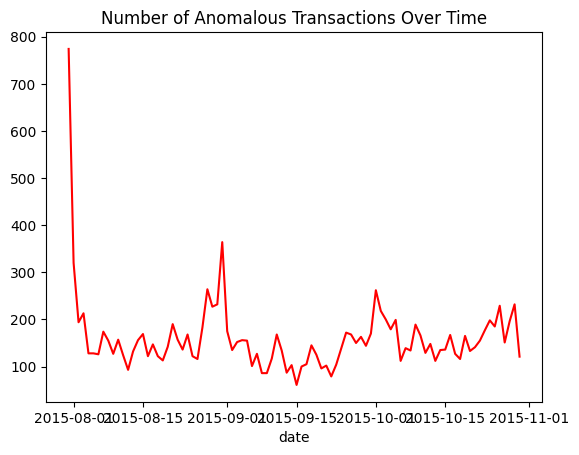

In [35]:
# Time-series plot of anomalies
anomalies_over_time = anomalies.groupby(anomalies['date'].dt.date).size()
anomalies_over_time.plot(color='red')
plt.title('Number of Anomalous Transactions Over Time')
plt.show()


The time-series plot above displays the number of anomalous transactions detected over time. This visualization can help Company ABC track and monitor suspicious activities and identify any emerging patterns or trends in fraudulent transactions.

In [36]:
def plot_customer_transactions(credit_card_number, data):
    """
    Plots transactions for a specific customer. 
    Fraudulent transactions are highlighted in red, and legitimate ones in green.
    """
    customer_data = data[data['credit_card'] == credit_card_number]
    
    # Splitting data into anomalies and normal transactions
    anomalies = customer_data[customer_data['is_anomaly'] == 1]
    normal = customer_data[customer_data['is_anomaly'] == 0]
    
    # Create a base map
    m = folium.Map(location=[customer_data['Lat'].mean(), customer_data['Long'].mean()], zoom_start=12)
    
    # Plotting anomalous transactions in red
    for _, row in anomalies.iterrows():
        folium.CircleMarker(
            location=[row['Lat'], row['Long']],
            radius=5,
            color="red",
            fill=True,
            fill_color="red",
            popup=f"Amount: ${row['transaction_dollar_amount']}\nDate: {row['date']}"
        ).add_to(m)
    
    # Plotting normal transactions in green
    for _, row in normal.iterrows():
        folium.CircleMarker(
            location=[row['Lat'], row['Long']],
            radius=3,
            color="green",
            fill=True,
            fill_color="green",
            popup=f"Amount: ${row['transaction_dollar_amount']}\nDate: {row['date']}"
        ).add_to(m)
    
    return m

# Replace with an actual credit card number from your dataset for demonstration
CUSTOMER_CREDIT_CARD_NUMBER = merged_data['credit_card'].iloc[15]
plot_customer_transactions(CUSTOMER_CREDIT_CARD_NUMBER, merged_data)

In [23]:
# Key statistics about the anomalies
total_anomalies = len(anomalies)
avg_transaction_amount = anomalies['transaction_dollar_amount'].mean()
max_transaction_amount = anomalies['transaction_dollar_amount'].max()

total_anomalies, avg_transaction_amount, max_transaction_amount


(14730, 402.3688764426341, 999.97)

Here are some key statistics about the anomalies:

1) Total Anomalous Transactions: 14,730

2) Average Transaction Amount of Anomalies: $402.37

3) Highest Transaction Amount Among Anomalies: $999.97

These insights can provide Company ABC with a quick overview of the suspicious activities detected by our model.

## Conclusion

Through this project, we have conducted an extensive analysis and identified potential fraudulent transactions using the Isolation Forest algorithm. The visualizations and statistics provide valuable insights that can assist Company ABC in enhancing their fraud detection capabilities.

For a more refined solution, integrating with labeled data and using a supervised learning approach would be beneficial. Periodic retraining of the model will also help in adapting to new patterns of fraud.
